In [1]:
!wget --no-check-certificate \
https://github.com/luthfi11/Learn-Machine-Learning/blob/master/TimeSeries/IOT-temp.csv?raw=true -O /tmp/dataset.csv

--2020-08-29 05:33:48--  https://github.com/luthfi11/Learn-Machine-Learning/blob/master/TimeSeries/IOT-temp.csv?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/luthfi11/Learn-Machine-Learning/raw/master/TimeSeries/IOT-temp.csv [following]
--2020-08-29 05:33:49--  https://github.com/luthfi11/Learn-Machine-Learning/raw/master/TimeSeries/IOT-temp.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/luthfi11/Learn-Machine-Learning/master/TimeSeries/IOT-temp.csv [following]
--2020-08-29 05:33:50--  https://raw.githubusercontent.com/luthfi11/Learn-Machine-Learning/master/TimeSeries/IOT-temp.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubuserconte

In [2]:
import pandas as pd
import numpy as np

data_train = pd.read_csv('/tmp/dataset.csv')
data_train['temp'] = data_train['temp'].astype(np.float32)
data_train.head()

,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,Room Admin,08-12-2018 09:30,29.0,In
1,__export__.temp_log_196131_7bca51bc,Room Admin,08-12-2018 09:30,29.0,In
2,__export__.temp_log_196127_522915e3,Room Admin,08-12-2018 09:29,41.0,Out
3,__export__.temp_log_196128_be0919cf,Room Admin,08-12-2018 09:29,41.0,Out
4,__export__.temp_log_196126_d30b72fb,Room Admin,08-12-2018 09:29,31.0,In


In [3]:
data_train.isnull().sum()

id            0
room_id/id    0
noted_date    0
temp          0
out/in        0
dtype: int64

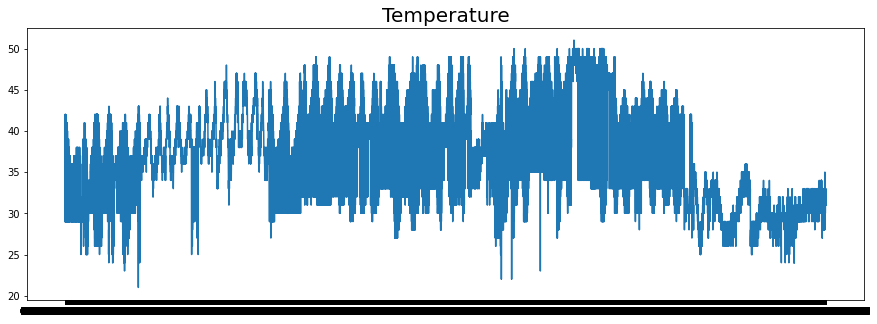

In [4]:
import matplotlib.pyplot as plt

dates = data_train['noted_date'].values
temp  = data_train['temp'].values
 
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature', fontsize=20);

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    
    return ds.batch(batch_size).prefetch(1)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dates, temp, test_size=0.2, shuffle=False)

print(min(y_train), max(y_train), (max(y_train)-min(y_train))*0.1)

21.0 51.0 3.0


In [7]:
import tensorflow as tf

train_set = windowed_dataset(y_train, window_size=60, batch_size=200, shuffle_buffer=1000)
validation_set = windowed_dataset(y_test, window_size=60, batch_size=200, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [8]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, validation_data=validation_set, epochs=5)

Epoch 1/5
391/391 [==============================] - 80s 206ms/step - loss: 35.4488 - mae: 35.9488 - val_loss: 28.0208 - val_mae: 28.5208
Epoch 2/5
391/391 [==============================] - 80s 204ms/step - loss: 18.9076 - mae: 19.3820 - val_loss: 1.8101 - val_mae: 2.2724
Epoch 3/5
391/391 [==============================] - 81s 207ms/step - loss: 2.1069 - mae: 2.5285 - val_loss: 1.7168 - val_mae: 2.1687
Epoch 4/5
391/391 [==============================] - 80s 206ms/step - loss: 2.0960 - mae: 2.5164 - val_loss: 1.7526 - val_mae: 2.2110
Epoch 5/5
391/391 [==============================] - 80s 205ms/step - loss: 2.0918 - mae: 2.5125 - val_loss: 1.6306 - val_mae: 2.0734
